## Yield Spread model

This notebook implements a model to predict new yield spreads from reference and trade history data. The model uses an attention layer between the two LSTM layers. The model is trained on data from 1 January 2023 to 1 March 2023. The test set is the month of March 2023. 

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-10-30 18:03:52.498937: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

2023-10-30 18:03:53.312367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-30 18:03:53.324620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-30 18:03:53.325300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-30 18:03:53.932435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-30 18:03:53.933145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-10-30 18:03:53.978509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-30 18:03:53.979172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-30 18:03:53.979732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Setting the environment variables

In [4]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../ahmad_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Initializing BigQuery client and GCP storage client

In [5]:
bq_client = bigquery.Client()
storage_client = storage.Client()

Declaring hyper-parameters

In [6]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT = 0.10
SEQUENCE_LENGTH = 5
NUM_FEATURES = 6

Checking if the treasury spreads and target attention features are present in PREDICTORS 

In [7]:
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')

#### Data Preparation
We grab the data from a GCP bucket. The data is prepared using the ficc python package. More insight on how the data is prepared can be found [here](https://github.com/Ficc-ai/ficc/blob/ahmad_ml/ml_models/sequence_predictors/data_prep/data_preparation.ipynb)

In [8]:
%%time
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
with fs.open('ahmad_data/processed_data_similar_histories_10_24.pkl') as f:
# with fs.open('automated_training/processed_data_test.pkl') as f:
    data = pd.read_pickle(f)

CPU times: user 29.9 s, sys: 10.5 s, total: 40.4 s
Wall time: 1min 28s


#### Date range for data

In [9]:
data.trade_date.max()

Timestamp('2023-08-31 00:00:00')

In [10]:
data.trade_date.min()

Timestamp('2023-05-02 00:00:00')

In [11]:
print(f'Restricting history to {SEQUENCE_LENGTH} trades')
data.trade_history = data.trade_history.apply(lambda x: x[:SEQUENCE_LENGTH])
data.target_attention_features = data.target_attention_features.apply(lambda x:x[:SEQUENCE_LENGTH])

Restricting history to 5 trades


In [12]:
data.trade_history.iloc[0].shape

(5, 6)

In [13]:
data.target_attention_features.iloc[0].shape

(1, 3)

In [14]:
data.sort_values('trade_datetime', inplace=True)

We don't give a predictions if yield is greater than 10

In [15]:
data = data[data['yield'] < 1000]

In [16]:
len(data)

3108924

### Creating features from trade history

This implementation is an adaption of Charles's implementation 

In [17]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

ys_variants = ["max_ys", "min_ys", "max_qty", "min_ago", "D_min_ago", "P_min_ago", "S_min_ago"]
ys_feats = ["_ys", "_ttypes", "_ago", "_qdiff"]
D_prev = dict()
P_prev = dict()
S_prev = dict()

def get_trade_history_columns():
    '''
    This function is used to create a list of columns
    '''
    YS_COLS = []
    for prefix in ys_variants:
        for suffix in ys_feats:
            YS_COLS.append(prefix + suffix)
    return YS_COLS

def extract_feature_from_trade(row, name, trade):
    yield_spread = trade[0]
    ttypes = ttype_dict[(trade[3],trade[4])] + row.trade_type
    seconds_ago = trade[5]
    quantity_diff = np.log10(1 + np.abs(10**trade[2] - 10**row.quantity))
    return [yield_spread, ttypes,  seconds_ago, quantity_diff]

def trade_history_derived_features(row):
    trade_history = row.trade_history
    trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip,trade)
    D_min_ago = 9        

    P_min_ago_t = P_prev.get(row.cusip,trade)
    P_min_ago = 9
    
    S_min_ago_t = S_prev.get(row.cusip,trade)
    S_min_ago = 9
    
    max_ys_t = trade; max_ys = trade[0]
    min_ys_t = trade; min_ys = trade[0]
    max_qty_t = trade; max_qty = trade[2]
    min_ago_t = trade; min_ago = trade[5]
    
    for trade in trade_history[0:]:
        #Checking if the first trade in the history is from the same block
        if trade[5] == 0: 
            continue
 
        if trade[0] > max_ys: 
            max_ys_t = trade
            max_ys = trade[0]
        elif trade[0] < min_ys: 
            min_ys_t = trade; 
            min_ys = trade[0]

        if trade[2] > max_qty: 
            max_qty_t = trade 
            max_qty = trade[2]
        if trade[5] < min_ago: 
            min_ago_t = trade; 
            min_ago = trade[5]
            
        side = ttype_dict[(trade[3],trade[4])]
        if side == "D":
            if trade[5] < D_min_ago: 
                D_min_ago_t = trade; D_min_ago = trade[5]
                D_prev[row.cusip] = trade
        elif side == "P":
            if trade[5] < P_min_ago: 
                P_min_ago_t = trade; P_min_ago = trade[5]
                P_prev[row.cusip] = trade
        elif side == "S":
            if trade[5] < S_min_ago: 
                S_min_ago_t = trade; S_min_ago = trade[5]
                S_prev[row.cusip] = trade
        else: 
            print("invalid side", trade)
    
    trade_history_dict = {"max_ys":max_ys_t,
                          "min_ys":min_ys_t,
                          "max_qty":max_qty_t,
                          "min_ago":min_ago_t,
                          "D_min_ago":D_min_ago_t,
                          "P_min_ago":P_min_ago_t,
                          "S_min_ago":S_min_ago_t}

    return_list = []
    for variant in ys_variants:
        feature_list = extract_feature_from_trade(row,variant,trade_history_dict[variant])
        return_list += feature_list
    
    return return_list

In [18]:
%%time
YS_COLS = get_trade_history_columns()
temp = data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
data[YS_COLS] = pd.DataFrame(temp.tolist(), index=data.index)

CPU times: user 1min 11s, sys: 10.6 s, total: 1min 21s
Wall time: 2min 18s


Adding trade history features to PREDICTORS list

In [19]:
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)

This feature is used to check if there are any NaN values in the trade history. **It is not used to train the model**. 

In [20]:
%%time
print(len(data))
data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))
data = data.dropna(subset=['trade_history_sum'])
print(len(data))

3108924
3108924
CPU times: user 23.2 s, sys: 7.52 s, total: 30.7 s
Wall time: 33 s


For the purpose of plotting, not used in training

In [21]:
data.purpose_sub_class.fillna(0, inplace=True)

Creating new ys label

In [22]:
data['new_ys'] = data['yield'] - data['new_ficc_ycl']
# data['diff_ys'] = data['new_ys'] - data['last_yield_spread']
# data['new_ys'] = data['yield'] - data['new_real_time_ficc_ycl']

Adding additional features proposed by Charles

In [23]:
data.last_trade_date = pd.to_datetime(data.last_trade_date)

In [24]:
data['last_duration'] = (data.last_calc_date - data.last_trade_date).dt.days

In [25]:
def duration(coupon, ytw, years, dollar_price, peryear=2):
    ytw = ytw.clip(0.001,np.inf)
    c = (coupon/100) / peryear
    y = (ytw/10000) / peryear
    n = years * peryear
    m = peryear
    macaulay_duration = ((1+y) / (m*y)) - ( (1 + y + n*(c-y)) / ((m*c* ((1+y)**n - 1)) + m*y))
    modified_duration = macaulay_duration / (1 + y)
    dv01 = modified_duration * dollar_price / 10000
    return dv01

def add_additional_feature(data):
    data['diff_ficc_ycl'] = data.new_ficc_ycl - data.last_ficc_ycl
    data['diff_ficc_treasury_spread'] = data.last_ficc_ycl - (data.treasury_rate * 100)
    data['dv01'] = duration(data.coupon, data.last_yield, data.last_duration, data.last_dollar_price)
    data['approx_dpd'] =  data.dv01 * data.diff_ficc_ycl
    data['overage'] =  (data.last_dollar_price + data.approx_dpd - data.next_call_price)
    #data['de_minimis_gap'] = data.last_dollar_price - data.de_minimis_threshold
    return data

# data = add_additional_feature(data)
# additional_features = ['diff_ficc_ycl','diff_ficc_treasury_spread','dv01','approx_dpd','overage']#,'de_minimis_gap']
# for i in additional_features:
#     if i not in NON_CAT_FEATURES:
#         NON_CAT_FEATURES.append(i)
#         PREDICTORS.append(i)

Selecting a subset of features for training. PREDICTORS are the features that we are going to use to train the model. More information about the feature set can be found [here](https://github.com/Ficc-ai/ficc_python/blob/d455bd30eca18f26a2535523530facad516dd90f/ficc/utils/auxiliary_variables.py#L120). We also select a set of additonal features, which are not used in training. These features are used to uderstand the results from the model.

In [26]:
auxiliary_features = ['dollar_price',
                     'calc_date', 
                     'trade_date',
                     'trade_datetime', 
                     'purpose_sub_class', 
                     'called_redemption_type', 
                     'calc_day_cat',
                     'yield',
                     'ficc_ycl',
                     'new_ys',
                     'trade_history_sum',
                     'new_ficc_ycl',
                     'days_to_refund',
                     'last_dollar_price',
                     'last_rtrs_control_number',
                     'is_called',
                     'federal_tax_status']

In [27]:
processed_data = data[IDENTIFIERS + PREDICTORS + auxiliary_features]

Checking for missing data and NaN values

In [28]:
print(len(processed_data))
processed_data.issue_amount = processed_data.issue_amount.replace([np.inf, -np.inf], np.nan)
processed_data.dropna(inplace=True, subset=PREDICTORS)
print(len(processed_data))

3108924
3108924


Here is a list of exclusions that we will be experimenting with. The model is trained with these exclusions.
<ul>
<li>Callable less than a year in the future
<li>Maturity less than a year in the future and more than 30 years in the future
</ul>


In [29]:
len(processed_data)

3108924

In [30]:
# processed_data = processed_data[(processed_data.days_to_call == 0) | (processed_data.days_to_call > np.log10(400))]
# processed_data = processed_data[(processed_data.days_to_refund == 0) | (processed_data.days_to_refund > np.log10(400))]
# processed_data = processed_data[(processed_data.days_to_maturity == 0) | (processed_data.days_to_maturity > np.log10(400))]
# processed_data = processed_data[processed_data.days_to_maturity < np.log10(30000)]

In [31]:
len(processed_data)

3108924

#### Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [32]:
categorical_feature_values = {'purpose_class' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                                 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
                                                 47, 48, 49, 50, 51, 52, 53],
                              'rating' : ['A', 'A+', 'A-', 'AA', 'AA+', 'AA-', 'AAA', 'B', 'B+', 'B-', 'BB', 'BB+', 'BB-',
                                         'BBB', 'BBB+', 'BBB-', 'CC', 'CCC', 'CCC+', 'CCC-' , 'D', 'NR', 'MR'],
                              'trade_type' : ['D', 'S', 'P'],
                              'incorporated_state_code' : ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'GU',
                                                         'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                                                         'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                                                         'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'US', 'UT', 'VA', 'VI',
                                                         'VT', 'WA', 'WI', 'WV', 'WY'] }

In [33]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep

In [34]:
processed_data.sort_values('trade_datetime',ascending=False,inplace=True)

#### Splitting the data into train and test sets

In [35]:
train_dataframe = processed_data[ (processed_data.trade_date < '08-01-2023')]

In [36]:
test_dataframe = processed_data[(processed_data.trade_date >= '08-01-2023') & (processed_data.trade_date <= '08-31-2023') ]

In [37]:
len(train_dataframe)

2255228

In [38]:
train_dataframe.trade_date.max()

Timestamp('2023-07-31 00:00:00')

In [39]:
len(test_dataframe)

853696

In [40]:
test_dataframe.trade_date.min()

Timestamp('2023-08-01 00:00:00')

##### Converting data into format suitable for the model

In [41]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [42]:
%%time
x_train = create_input(train_dataframe)
y_train = train_dataframe.new_ys
#y_train = train_dataframe.diff_ys

CPU times: user 13 s, sys: 456 ms, total: 13.5 s
Wall time: 13.4 s


In [43]:
%%time
x_test = create_input(test_dataframe)
y_test = test_dataframe.new_ys
#y_test = test_dataframe.diff_ys

CPU times: user 4.96 s, sys: 54.8 ms, total: 5.01 s
Wall time: 5.01 s


In [44]:
x_train[0].shape

(2255228, 5, 6)

In [45]:
x_test[2].shape

(853696, 48)

## LightGBM

In [46]:
def gbmprep(df):
    df[CATEGORICAL_FEATURES ] = df[CATEGORICAL_FEATURES].astype('category')
    df[NON_CAT_FEATURES + BINARY ] = df[NON_CAT_FEATURES + BINARY].astype('float64')
    df = df.drop(columns = ['trade_history','target_attention_features'])
    return df

In [47]:
trainlabel = train_dataframe.new_ys
testlabel = test_dataframe.new_ys

In [48]:
%%time
gbt_td = gbmprep(train_dataframe[PREDICTORS])
gbtmodel = LGBMRegressor(num_iterations=300, max_depth=12, num_leaves=300, objective='mae', verbosity=-1)
gbtmodel.fit(gbt_td, trainlabel) 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


CPU times: user 16min 49s, sys: 3.05 s, total: 16min 52s
Wall time: 45.7 s


LGBMRegressor(max_depth=12, num_iterations=300, num_leaves=300, objective='mae',
              verbosity=-1)

In [49]:
%%time 
gbt_pred = gbtmodel.predict(gbmprep(test_dataframe[PREDICTORS]))
delta = testlabel - gbt_pred
print(delta.abs().mean())

11.004939015339874
CPU times: user 1min 31s, sys: 787 ms, total: 1min 32s
Wall time: 7.41 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

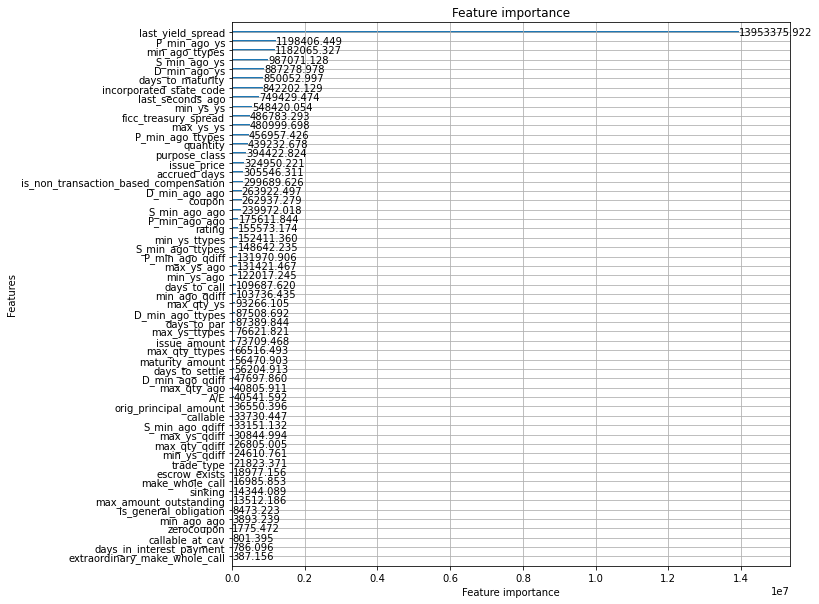

In [50]:
lightgbm.plot_importance(gbtmodel, 
                         figsize=(10,10), 
                         importance_type='gain')

# Neural Network Implementation

#### Adapting Normalization layers to the non categorical features

In [51]:
# Normalization layer for the trade history
trade_history_normalizer = Normalization(name='Trade_history_normalizer')
trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

2023-10-30 18:09:50.347211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-30 18:09:50.347979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-30 18:09:50.348580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-30 18:09:50.349258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-30 18:09:50.349825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [52]:
# Normalization layer for the non-categorical and binary features
noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

#### Setting the seed for intialization of the layers

In [53]:
tf.keras.utils.set_random_seed(10)

#### Implementation of the model

We define an attention mechanism to weigh the importance of the target trade with respect to the output of the second LSTM layer. The attention mechanism first calculates the dot product between the LSTM output and the target trade using the Dot layer. The axes=\[2, 2\] means that we want to perform a dot product between the last axis of lstm ouput and the last axis of target trade sequence. The result is passed through a softmax activation function using the Activation layer to obtain the attention weights. The attention weights indicate the relative importance of each lstm hidden state with the target trade. Finally, the attention weights are used to calculate a context vector as a weighted sum of the traget trade using another Dot layer.

In [54]:
inputs = []
layer = []

############## INPUT BLOCK ###################
trade_history_input = layers.Input(name="trade_history_input", 
                                   shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                   dtype = tf.float32) 

target_attention_input = layers.Input(name="target_attention_input", 
                                   shape=(1, 3), 
                                   dtype = tf.float32) 


inputs.append(trade_history_input)
inputs.append(target_attention_input)

inputs.append(layers.Input(
    name="NON_CAT_AND_BINARY_FEATURES",
    shape=(len(NON_CAT_FEATURES + BINARY),)
))


layer.append(noncat_binary_normalizer(inputs[2]))
####################################################


############## TRADE HISTORY MODEL #################

lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                         activation='tanh',
                         input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                         return_sequences = True,
                         name='LSTM'))

lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                activation='tanh',
                                                input_shape=(SEQUENCE_LENGTH,50),
                                                return_sequences = True,
                                                name='LSTM_2'))



features = lstm_layer(trade_history_normalizer(inputs[0]))
features = lstm_layer_2(features)


attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
attention = layers.Activation('softmax')(attention)

context_vector = layers.Dot(axes=[1, 1])([features, attention])
context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)

context_vector = layers.BatchNormalization()(context_vector)
trade_history_output = layers.Dense(100, 
                                    activation='relu')(context_vector)

####################################################

############## REFERENCE DATA MODEL ################
# global encoders
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")(layers.Embedding(input_dim = fmax[f]+1,
                                                                   output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                   input_length= 1,
                                                                   name = f + "_embed")(fin))
    layer.append(embedded)

    
reference_hidden = layers.Dense(400,
                                activation='relu',
                                name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

reference_hidden = layers.BatchNormalization()(reference_hidden)
reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

reference_output = layers.Dense(100,activation='tanh',name='reference_hidden_3')(reference_hidden2)

####################################################

feed_forward_input = layers.concatenate([reference_output, trade_history_output])

hidden = layers.Dense(300,activation='relu')(feed_forward_input)
hidden = layers.BatchNormalization()(hidden)
hidden = layers.Dropout(DROPOUT)(hidden)

hidden2 = layers.Dense(100,activation='relu')(hidden)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(DROPOUT)(hidden2)

final = layers.Dense(1)(hidden2)

model = keras.Model(inputs=inputs, outputs=final)

In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rating (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 incorporated_state_code (Input  [(None, 1)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 trade_type (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 purpose_class (InputLayer)     [(None, 1)]          0           []                           

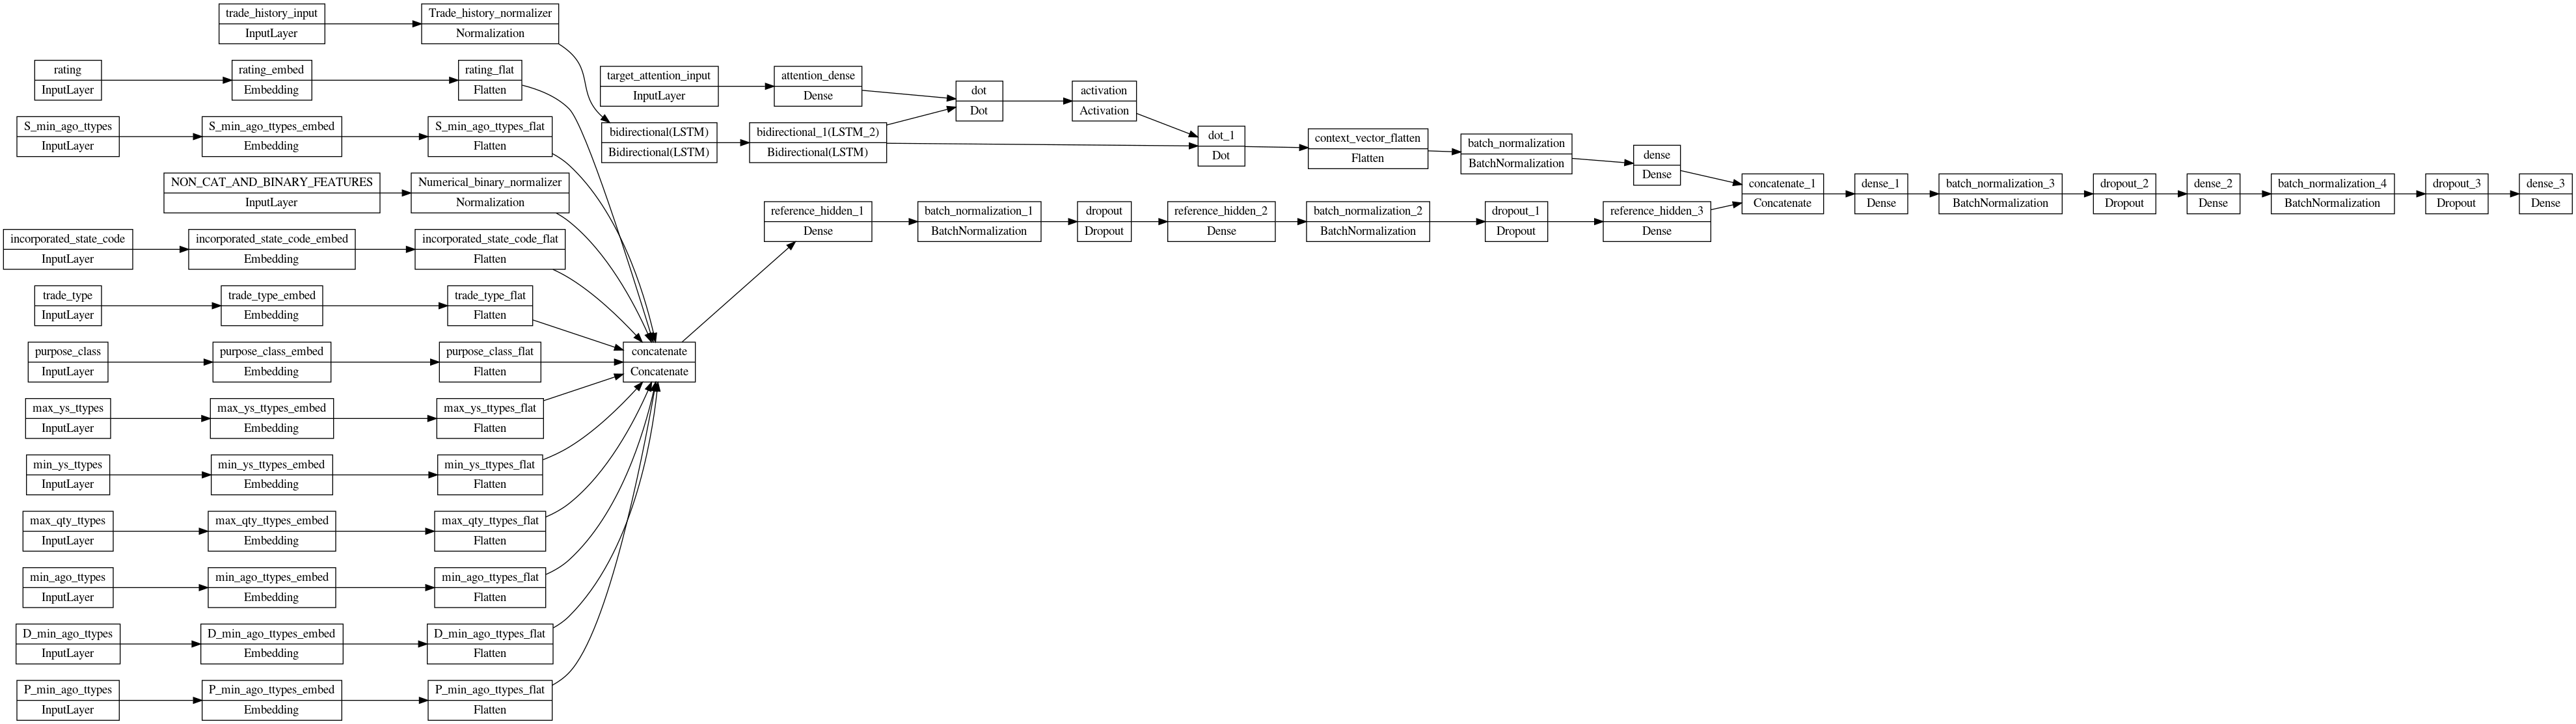

In [56]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [57]:
for i in NON_CAT_FEATURES + BINARY + CATEGORICAL_FEATURES:
    print(i)

quantity
days_to_maturity
days_to_call
coupon
issue_amount
last_seconds_ago
last_yield_spread
days_to_settle
days_to_par
maturity_amount
issue_price
orig_principal_amount
max_amount_outstanding
accrued_days
days_in_interest_payment
A/E
ficc_treasury_spread
max_ys_ys
max_ys_ago
max_ys_qdiff
min_ys_ys
min_ys_ago
min_ys_qdiff
max_qty_ys
max_qty_ago
max_qty_qdiff
min_ago_ys
min_ago_ago
min_ago_qdiff
D_min_ago_ys
D_min_ago_ago
D_min_ago_qdiff
P_min_ago_ys
P_min_ago_ago
P_min_ago_qdiff
S_min_ago_ys
S_min_ago_ago
S_min_ago_qdiff
callable
sinking
zerocoupon
is_non_transaction_based_compensation
is_general_obligation
callable_at_cav
extraordinary_make_whole_call
make_whole_call
has_unexpired_lines_of_credit
escrow_exists
rating
incorporated_state_code
trade_type
purpose_class
max_ys_ttypes
min_ys_ttypes
max_qty_ttypes
min_ago_ttypes
D_min_ago_ttypes
P_min_ago_ttypes
S_min_ago_ttypes


In [58]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [59]:
fit_callbacks = [
    #WandbCallback(save_model=False),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,
        verbose=0,
        mode="auto",
        restore_best_weights=True,
    ),
    time_callback
]

In [60]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.MeanAbsoluteError(),)
              #loss=keras.losses.MeanAbsoluteError())

In [61]:
%%time 
history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=BATCH_SIZE, 
                    verbose=1, 
                    validation_split=0.1, 
                    callbacks=fit_callbacks,
                    use_multiprocessing=True,
                    workers=8)

Epoch 1/100


2023-10-30 18:10:04.723969: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14488961024 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-10-30 18:10:06.844340: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


2028/2030 [============================>.] - ETA: 0s - loss: 37.0837

2023-10-30 18:10:38.299354: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14488961024 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


2030/2030 [==============================] - 41s 16ms/step - loss: 37.0769 - val_loss: 32.1564
Epoch 2/100
2030/2030 [==============================] - 31s 15ms/step - loss: 22.9982 - val_loss: 17.6583
Epoch 3/100
2030/2030 [==============================] - 31s 15ms/step - loss: 13.7794 - val_loss: 13.0139
Epoch 4/100
2030/2030 [==============================] - 31s 15ms/step - loss: 12.6194 - val_loss: 12.6621
Epoch 5/100
2030/2030 [==============================] - 30s 15ms/step - loss: 12.3521 - val_loss: 12.4364
Epoch 6/100
2030/2030 [==============================] - 30s 15ms/step - loss: 12.1704 - val_loss: 12.3301
Epoch 7/100
2030/2030 [==============================] - 30s 15ms/step - loss: 12.0287 - val_loss: 12.2390
Epoch 8/100
2030/2030 [==============================] - 32s 16ms/step - loss: 11.9062 - val_loss: 12.2803
Epoch 9/100
2030/2030 [==============================] - 32s 16ms/step - loss: 11.7964 - val_loss: 12.0136
Epoch 10/100
2030/2030 [=========================

2030/2030 [==============================] - 31s 15ms/step - loss: 10.1728 - val_loss: 11.3169
CPU times: user 1h 5min 46s, sys: 13min 59s, total: 1h 19min 45s
Wall time: 39min 27s


#### Plotting train vs validation loss

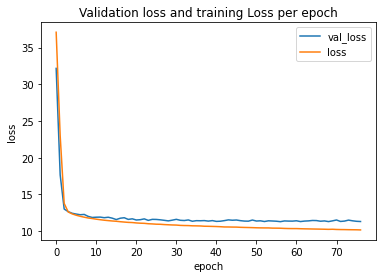

In [62]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Saving the model

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
file_timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')
print(f"file time stamp : {file_timestamp}")

# print("Saving encoders and uploading encoders")
# with open(f"encoders_august.pkl",'wb') as file:
#     pickle.dump(encoders,file)    
# # upload_data(storage_client, 'ahmad_data', f"encoders.pkl")

print("Saving and uploading model")
model.save(f"saved_model_baseline_similar_{file_timestamp}")
# import shutil
# shutil.make_archive(f"model_july_26", 'zip', f"saved_model_{file_timestamp}")
# upload_data(storage_client, 'ahmad_data', f"model_july_26.zip")

file time stamp : 2023-10-30-20-01
Saving and uploading model


2023-10-30 20:01:36.978480: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


#### Gigaflops for one epoch of training

In [64]:
avg_time = np.mean(time_callback.times)

In [65]:
n = len(x_train[0])
p = model.count_params()
avg_time = np.mean(time_callback.times)
gflops = ((n*p*2*3)/avg_time)/10**9

print(gflops)

245.6484774242196


### Test accuracy on the entire test set

In [66]:
test_dataframe['predicted_ys'] = model.predict(x_test, batch_size=BATCH_SIZE) 
test_dataframe['predicted_ytw'] = test_dataframe['new_ficc_ycl'] + test_dataframe['predicted_ys']

2023-10-30 18:49:33.819544: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14488961024 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [67]:
test_dataframe['absolute_delta'] = np.abs(test_dataframe.new_ys - test_dataframe.predicted_ys)

In [68]:
print(f"Test loss: {round(np.mean(np.abs(test_dataframe.new_ys - test_dataframe.predicted_ys)), 3)}")

Test loss: 10.111


In [69]:
print(f"YTW loss: {round(np.mean(np.abs(test_dataframe['yield'] - test_dataframe.predicted_ytw)), 3)}")

YTW loss: 10.111


In [70]:
print(f"MAD yield spread model: {round(np.median(np.abs(test_dataframe.new_ys - test_dataframe.predicted_ys)), 3)}")

MAD yield spread model: 5.649


#### Accuracy on a daily basis for dealer dealer trades

In [71]:
for d in [d for d in pd.date_range(start="08/01/2023",end="08/31/2023",freq='D')]:
    next_day = test_dataframe[(test_dataframe.trade_date == d)].copy()
    if len(next_day) == 0:
        continue
    next_day_test = create_input(next_day)  
    next_day_preds = model.predict(next_day_test, batch_size=BATCH_SIZE)
    error = next_day.new_ys - next_day_preds.reshape(-1)
    MAE = np.mean(np.abs(error))
    print(f"Date :{d.date()} MAE:{np.round(MAE,3)}" )

Date :2023-08-01 MAE:10.315
Date :2023-08-02 MAE:10.467
Date :2023-08-03 MAE:10.758
Date :2023-08-04 MAE:10.191
Date :2023-08-07 MAE:10.493
Date :2023-08-08 MAE:9.882
Date :2023-08-09 MAE:9.697
Date :2023-08-10 MAE:9.541
Date :2023-08-11 MAE:9.576
Date :2023-08-14 MAE:10.295
Date :2023-08-15 MAE:9.531
Date :2023-08-16 MAE:9.612
Date :2023-08-17 MAE:10.934
Date :2023-08-21 MAE:11.337
Date :2023-08-22 MAE:10.917
Date :2023-08-23 MAE:10.359
Date :2023-08-24 MAE:10.023
Date :2023-08-25 MAE:10.02
Date :2023-08-28 MAE:9.92
Date :2023-08-29 MAE:9.994
Date :2023-08-30 MAE:9.666
Date :2023-08-31 MAE:9.519


### Test accuracy on large dealer-dealer trades
We define large as any trade which is above $500,000

In [72]:
true_mid = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]# & (test_dataframe.coupon == 4)]

In [73]:
len(true_mid)

12325

In [74]:
%%time
x_true_mid = create_input(true_mid)
y_true_mid = true_mid.new_ys

CPU times: user 86 ms, sys: 0 ns, total: 86 ms
Wall time: 85.3 ms


In [75]:
round(np.mean(np.abs(true_mid.new_ys - true_mid.predicted_ys)), 3)

6.985

In [76]:
%%time
mae = model.evaluate(x_true_mid, y_true_mid, verbose=1, batch_size = BATCH_SIZE)
print(f"Test MAE: {round(mae, 3)}")
# wandb.log({"Dealer Dealer true mid Test MAE": mae})

13/13 [==============================] - 0s 5ms/step - loss: 6.9847
Test MAE: 6.985
CPU times: user 192 ms, sys: 32.8 ms, total: 225 ms
Wall time: 157 ms


### Plotting new ys vs predicted ys

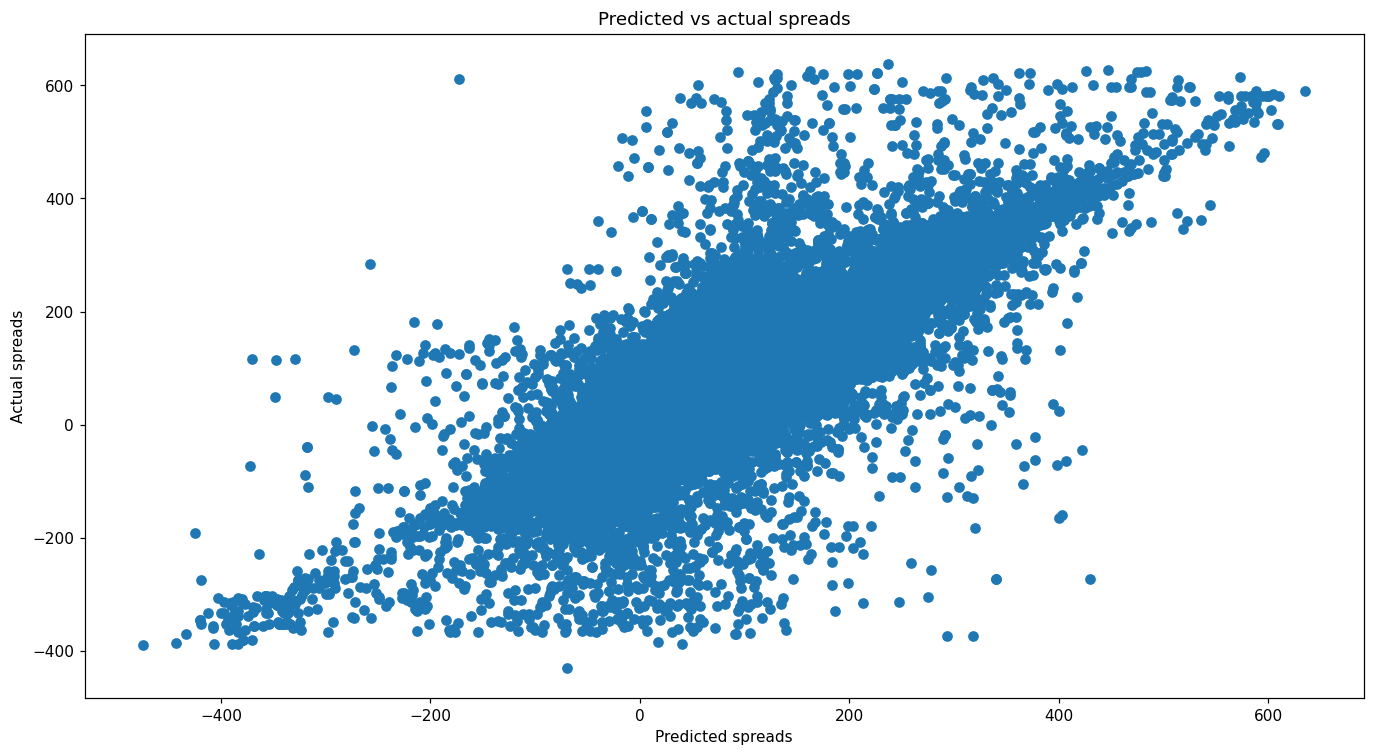

In [77]:
plt.figure(figsize=(15, 8), dpi=110)
plt.xlabel('Predicted spreads')
plt.ylabel('Actual spreads')
plt.title('Predicted vs actual spreads')
plt.scatter(test_dataframe.predicted_ys, test_dataframe.new_ys)

In [78]:
test_dataframe[(test_dataframe.new_ys > 180)&(test_dataframe.predicted_ys < -400)][['cusip','trade_datetime','yield','new_ys','predicted_ys','last_yield_spread','calc_date']]

,cusip,trade_datetime,yield,new_ys,predicted_ys,last_yield_spread,calc_date
